In [1]:
import cv2

In [2]:
import math

def calculateCartesianCoordinates(coordinate):
    radius, azimuth = coordinate[0], coordinate[1]
    return np.array([radius * math.sin(math.radians(azimuth)), radius * math.cos(math.radians(azimuth)), 0])

def convertToCartesian(coordinates):
    return np.array(list(map(calculateCartesianCoordinates, coordinates)))

In [3]:
from __future__ import print_function
import yaml
try:
    from yaml import CLoader as Loader
except ImportError:
    from yaml import Loader

import gzip
import os.path
import numpy as np

# Reading yml.gz data

# Сhange this to where data is stored
data_dir = '/Users/bulatgaliev/GitHub/Masters_diploma/radar_calib_data'
#'/prun/mipt/student_nirs/2018/galiev_bulat/radar_calib_data'


def ungzip(yaml_in_directory):
    # наши ямлы требуют небольшой ректификации перед использованием
    ungzipped = gzip.open(yaml_in_directory, 'rt')
    ungzipped.readline()
    ungzipped = ungzipped.read()
    ungzipped = ungzipped.replace(':', ': ')

    # собственно парсинг
    yml = yaml.load(ungzipped, Loader=Loader)
    return yml

def read_image_grabmsecs(yml_path):
    yml_data = ungzip(yml_path)
    image_frames = [sh['leftImage']
                    for sh in yml_data['shots'] if 'leftImage' in sh.keys()]
    
    data = np.zeros(shape=(len(image_frames), 1), dtype=int)
    i_real = 0
    for i_fr in image_frames:
        data[i_real, 0] = int(i_fr['grabMsec'])
        i_real += 1

    data = data[:i_real, :]
    return data

grabmsecs = np.concatenate((read_image_grabmsecs(os.path.join(data_dir, 't24.305.026.info.yml.gz')).flatten(),
                      read_image_grabmsecs(os.path.join(data_dir, 't24.305.027.info.yml.gz')).flatten(),
                      read_image_grabmsecs(os.path.join(data_dir, 't24.305.028.info.yml.gz')).flatten(),
                      read_image_grabmsecs(os.path.join(data_dir, 't24.305.029.info.yml.gz')).flatten()))

In [4]:
import yaml
import numpy as np

# Reading yml data

# Сhange this to where data is stored
camera_path = os.path.join(data_dir, 'calibs', 'camera.yml')

try:
    from yaml import CLoader as Loader
except ImportError:
    from yaml import Loader
    
def read_yml(yml_path):
    yml = yaml.load(yml_path, Loader=Loader)
    return yml

def opencv_matrix(loader, node):
    mapping = loader.construct_mapping(node, deep=True)
    dt = np.dtype(mapping["dt"])
    mat = np.array(mapping["data"], dt)
    mat.resize(mapping["rows"], mapping["cols"])
    return mat

stream = open(camera_path, 'r')
stream.readline()
stream = stream.read()
stream = stream.replace(':', ': ')
yaml.add_constructor(u"tag:yaml.org,2002:opencv-matrix", opencv_matrix)
data = yaml.load(stream)


In [5]:
# Creating Camera object for central projection 

class Camera:
    '''Pinhole camera projection'''
    def __init__(self, r, t, K, size):
        if  not (t.shape == (3,) and r.shape == (3,) and K.shape == (3,3)):
            raise ValueError('bad constructor args')
        self.r = r
        self.t = t
        self.K = K
        self.size = size
        R = rot_matrix(r)
        self.P = K.dot(np.hstack([R, t.reshape(t.shape[0], 1)]))
        pass
    
    def translate(self, points, t):
        return np.array([point + t for point in points])
    
    def rotate(self, points, rot_mat):
        return np.array([rot_mat.dot(point) for point in points])
    
    def transform(self, points):
        return self.rotate(points, rot_matrix([np.pi / 2.0, 0, 0]))
    
    def project(self, points):
        if points.shape[1] == 3:
            R = rot_matrix(r)
            translated = self.translate(points, self.t)
#             print("Translated: ", translated)
            rotated = self.rotate(translated, R.T)
#             print("Rotated: ", rotated)
            tranformed = self.transform(rotated)
#             print("Transformed: ", tranformed)
            homo_pts = self.K.dot(tranformed.T).T
#             print("homo_pts: ", homo_pts)
        elif points.shape[1] == 4:
            homo_pts = self.P.dot(points.T)
        else:
            raise ValueError('Incorrect points size for Camera.project: %s' % \
                             str(points.shape))
        return homo_pts[:, : 2] / homo_pts[:, 2].reshape(-1, 1)
    
def rot_matrix(angles):
    cos = [np.math.cos(a) for a in angles]
    sin = [np.math.sin(a) for a in angles]
    Rz = np.array([[cos[2], -sin[2], 0],
                   [sin[2], cos[2],  0],
                   [     0,      0,  1]])

    Ry = np.array([[ cos[1], 0, sin[1]],
                   [      0, 1,      0],
                   [-sin[1], 0, cos[1]]])

    Rx = np.array([[1,      0,       0],
                   [0, cos[0], -sin[0]],
                   [0, sin[0], cos[0]]])
    #Rs = [Rx, Ry, Rz]
    return Ry.dot(Rx).dot(Rz)
    
K = data["K"]
r = data["r"].flatten()
t = data["t"].flatten()
img_size = (data["sz"][0], data["sz"][1])
print('K = ', K)
print('r = ', r)
print('t = ', t)
print('Image size = ', img_size)
cam = Camera(r=r, t=-t, K=K, size=img_size)

K =  [[1.39022723e+03 0.00000000e+00 9.62339056e+02]
 [0.00000000e+00 1.39022723e+03 5.31100969e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
r =  [ 0.04163906 -0.02612186 -0.02203633]
t =  [ 0.15882312 -1.58        1.25712767]
Image size =  (1920, 1080)


In [6]:
def frange(x, y, jump):
    while x < y:
        yield round(x, 1)
        x += jump

In [7]:
cartesianGridPoints = []
for x in frange(-10, 10, 0.2):
    if float(x).is_integer():
        for y in frange(0, 10, 0.2):
            cartesianGridPoints.append([x, y, 0])
    else:
        for y in frange(0, 10, 1):
            cartesianGridPoints.append([x, y, 0])
gridPoints = cam.project(np.array(cartesianGridPoints))

In [8]:
%matplotlib inline
import math
import numpy as np
import matplotlib.pyplot as plt

#  ICP parameters
EPS = 0.0001
MAXITER = 100

show_animation = True


def ICP_matching(ppoints, cpoints):
    """
    Iterative Closest Point matching
    - input
    ppoints: 2D points in the previous frame
    cpoints: 2D points in the current frame
    - output
    R: Rotation matrix
    T: Translation vector
    """
    H = None  # homogeneraous transformation matrix

    dError = 1000.0
    preError = 1000.0
    count = 0

    while dError >= EPS:
        count += 1

        if show_animation:
            plt.cla()
            plt.plot(ppoints[0, :], ppoints[1, :], ".r")
            plt.plot(cpoints[0, :], cpoints[1, :], ".b")
            plt.plot(0.0, 0.0, "xr")
            plt.axis("equal")
            plt.pause(1.0)

        inds, error = nearest_neighbor_assosiation(ppoints, cpoints)
        Rt, Tt = SVD_motion_estimation(ppoints[:, inds], cpoints)

        # update current points
        cpoints = (Rt * cpoints) + Tt

        H = update_homogenerous_matrix(H, Rt, Tt)

        dError = abs(preError - error)
        preError = error
        print("Residual:", error)

        if dError <= EPS:
            print("Converge", error, dError, count)
            break
        elif MAXITER <= count:
            print("Not Converge...", error, dError, count)
            break
    
    R = np.matrix(H[0:2, 0:2])
    T = np.matrix(H[0:2, 2])

    return R, T, np.array(cpoints.T)


def update_homogenerous_matrix(Hin, R, T):

    H = np.matrix(np.zeros((3, 3)))

    H[0, 0] = R[0, 0]
    H[1, 0] = R[1, 0]
    H[0, 1] = R[0, 1]
    H[1, 1] = R[1, 1]
    H[2, 2] = 1.0

    H[0, 2] = T[0, 0]
    H[1, 2] = T[1, 0]

    if Hin is None:
        return H
    else:
        return Hin * H


def nearest_neighbor_assosiation(ppoints, cpoints):

    # calc the sum of residual errors
    dcpoints = ppoints - cpoints
    d = np.linalg.norm(dcpoints, axis=0)
    error = sum(d)

    # calc index with nearest neighbor assosiation
    inds = []
    for i in range(cpoints.shape[1]):
        minid = -1
        mind = float("inf")
        for ii in range(ppoints.shape[1]):
            d = np.linalg.norm(ppoints[:, ii] - cpoints[:, i])

            if mind >= d:
                mind = d
                minid = ii

        inds.append(minid)

    return inds, error


def SVD_motion_estimation(ppoints, cpoints):
    pm = np.matrix(np.mean(ppoints, axis=1))
    cm = np.matrix(np.mean(cpoints, axis=1))
    print(pm)
    print(ppoints)
    pshift = np.matrix(ppoints - pm)
    cshift = np.matrix(cpoints - cm)

    W = cshift * pshift.T
    u, s, vh = np.linalg.svd(W)

    R = (u * vh).T
    t = pm - R * cm

    return R, t

def align(radarPoints, cameraPoints):
    i = 0
    while len(cameraPoints) != len(radarPoints):
        cameraPoints = np.vstack((cameraPoints, cameraPoints[i%len(cameraPoints)]))
        print(cameraPoints)
        i+=1
# TwoDRadarPoints = points
# TwoDCameraPoints = np.concatenate((currentFrameCameraDetectionsValues, 
#                                    currentFrameCameraDetectionsValues, 
#                                    currentFrameCameraDetectionsValues,
#                                    currentFrameCameraDetectionsValues, 
#                                    currentFrameCameraDetectionsValues, 
#                                    currentFrameCameraDetectionsValues,
#                                    currentFrameCameraDetectionsValues))
    ppoints = np.matrix(cameraPoints.T)
    cpoints = np.matrix(radarPoints.T)
    R, T, newcPoints = ICP_matching(ppoints, cpoints)
    return newcPoints

parsed 4 files. Rows:  21836  empty files number: 0
empty files list: [  ]

parsed 4 files. Rows:  2415  empty files number: 0
empty files list: [  ]

272
275
270
[[1069  622]
 [ 886  584]
 [ 851  574]
 [1069  622]]
[[1069  622]
 [ 886  584]
 [ 851  574]
 [1069  622]
 [ 886  584]]
[[1069  622]
 [ 886  584]
 [ 851  574]
 [1069  622]
 [ 886  584]
 [ 851  574]]
[[1069  622]
 [ 886  584]
 [ 851  574]
 [1069  622]
 [ 886  584]
 [ 851  574]
 [1069  622]]
[[1069  622]
 [ 886  584]
 [ 851  574]
 [1069  622]
 [ 886  584]
 [ 851  574]
 [1069  622]
 [ 886  584]]
[[1069  622]
 [ 886  584]
 [ 851  574]
 [1069  622]
 [ 886  584]
 [ 851  574]
 [1069  622]
 [ 886  584]
 [ 851  574]]
[[1069  622]
 [ 886  584]
 [ 851  574]
 [1069  622]
 [ 886  584]
 [ 851  574]
 [1069  622]
 [ 886  584]
 [ 851  574]
 [1069  622]]
[[1069  622]
 [ 886  584]
 [ 851  574]
 [1069  622]
 [ 886  584]
 [ 851  574]
 [1069  622]
 [ 886  584]
 [ 851  574]
 [1069  622]
 [ 886  584]]
[[1069  622]
 [ 886  584]
 [ 851  574]
 [1069  62

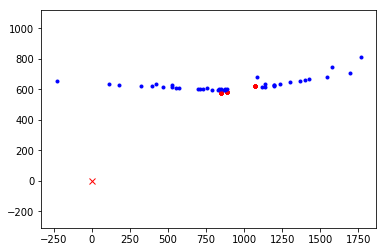

[[944.02564103]
 [594.71794872]]
[[ 851  886 1069 1069  851  851 1069  851  851  886  851  851  851  851
  1069  851 1069 1069 1069  851 1069  851  886 1069 1069 1069  851  851
   851 1069 1069  886  851 1069 1069  851  851 1069  851]
 [ 574  584  622  622  574  574  622  574  574  584  574  574  574  574
   622  574  622  622  622  574  622  574  584  622  622  622  574  574
   574  622  622  584  574  622  622  574  574  622  574]]
Residual: 14397.144318070637


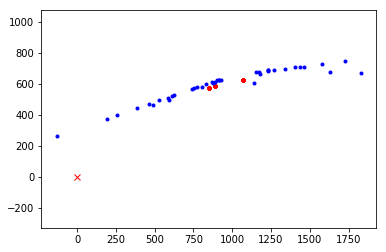

[[946.71794872]
 [595.48717949]]
[[ 851  886 1069 1069  851  851 1069  851  851  886  886  851  886  851
  1069  851 1069 1069 1069  851 1069  851  886 1069 1069 1069  851  886
   851 1069 1069  886  851 1069 1069  851  851 1069  851]
 [ 574  584  622  622  574  574  622  574  574  584  584  574  584  574
   622  574  622  622  622  574  622  574  584  622  622  622  574  584
   574  622  622  584  574  622  622  574  574  622  574]]
Residual: 14239.845448419408


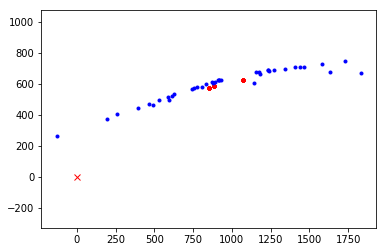

[[946.71794872]
 [595.48717949]]
[[ 851  886 1069 1069  851  851 1069  851  851  886  886  851  886  851
  1069  851 1069 1069 1069  851 1069  851  886 1069 1069 1069  851  886
   851 1069 1069  886  851 1069 1069  851  851 1069  851]
 [ 574  584  622  622  574  574  622  574  574  584  584  574  584  574
   622  574  622  622  622  574  622  574  584  622  622  622  574  584
   574  622  622  584  574  622  622  574  574  622  574]]
Residual: 14240.19295335675


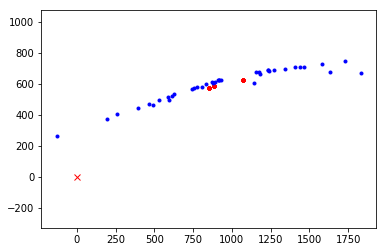

[[946.71794872]
 [595.48717949]]
[[ 851  886 1069 1069  851  851 1069  851  851  886  886  851  886  851
  1069  851 1069 1069 1069  851 1069  851  886 1069 1069 1069  851  886
   851 1069 1069  886  851 1069 1069  851  851 1069  851]
 [ 574  584  622  622  574  574  622  574  574  584  584  574  584  574
   622  574  622  622  622  574  622  574  584  622  622  622  574  584
   574  622  622  584  574  622  622  574  574  622  574]]
Residual: 14240.192953356753
Converge 14240.192953356753 1.8189894035458565e-12 4
[[-230.95612442  653.12478196]
 [ 886.39313769  601.40207692]
 [1196.71064644  626.0025341 ]
 [1424.3160758   666.54252709]
 [ 757.87973077  609.70703353]
 [ 789.67056236  598.16296762]
 [1117.71300832  614.15412745]
 [ 320.21452287  623.72666015]
 [ 109.63353109  638.11513652]
 [ 877.14405311  597.59323821]
 [ 831.19545119  595.66996859]
 [ 526.52682622  612.52996962]
 [ 845.50100879  599.30463934]
 [ 571.75918905  607.54138307]
 [1138.8492205   616.64538824]
 [ 418.91717689

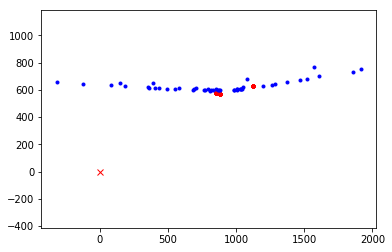

[[963.34042553]
 [600.34042553]]
[[ 851  851 1123  851  851 1123 1123  879  851  851 1123  851  851 1123
   851  851  851  851 1123 1123 1123  851 1123 1123  851  851  851 1123
   851 1123 1123  851  851 1123  851  879  851  879  851 1123 1123 1123
  1123  851  879  851 1123]
 [ 580  580  632  580  580  632  632  572  580  580  632  580  580  632
   580  580  580  580  632  632  632  580  632  632  580  580  580  632
   580  632  632  580  580  632  580  572  580  572  580  632  632  632
   632  580  572  580  632]]
Residual: 18312.09334279018


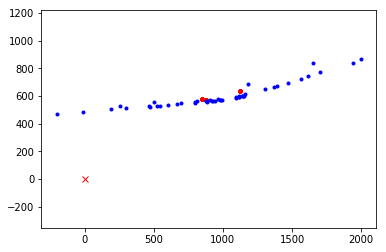

[[978.4893617 ]
 [601.53191489]]
[[ 851  879 1123  851  879 1123 1123 1123  879  851 1123  879  851 1123
   879  851  879  851 1123 1123 1123  851 1123 1123  851  879  851 1123
   851 1123 1123  851  879 1123  851 1123  851  879  851 1123 1123 1123
  1123  851  879  851 1123]
 [ 580  572  632  580  572  632  632  632  572  580  632  572  580  632
   572  580  572  580  632  632  632  580  632  632  580  572  580  632
   580  632  632  580  572  632  580  632  580  572  580  632  632  632
   632  580  572  580  632]]
Residual: 18361.8469017416


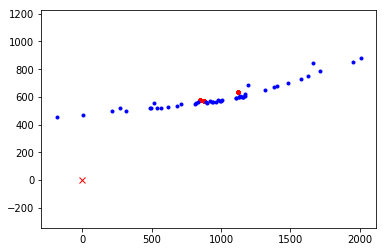

[[978.4893617 ]
 [601.53191489]]
[[ 851  879 1123  851  879 1123 1123 1123  879  851 1123  879  851 1123
   879  851  879  851 1123 1123 1123  851 1123 1123  851  879  851 1123
   851 1123 1123  851  879 1123  851 1123  851  879  851 1123 1123 1123
  1123  851  879  851 1123]
 [ 580  572  632  580  572  632  632  632  572  580  632  572  580  632
   572  580  572  580  632  632  632  580  632  632  580  572  580  632
   580  632  632  580  572  632  580  632  580  572  580  632  632  632
   632  580  572  580  632]]
Residual: 18552.62484390605


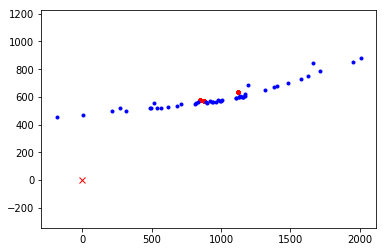

[[978.4893617 ]
 [601.53191489]]
[[ 851  879 1123  851  879 1123 1123 1123  879  851 1123  879  851 1123
   879  851  879  851 1123 1123 1123  851 1123 1123  851  879  851 1123
   851 1123 1123  851  879 1123  851 1123  851  879  851 1123 1123 1123
  1123  851  879  851 1123]
 [ 580  572  632  580  572  632  632  632  572  580  632  572  580  632
   572  580  572  580  632  632  632  580  632  632  580  572  580  632
   580  632  632  580  572  632  580  632  580  572  580  632  632  632
   632  580  572  580  632]]
Residual: 18552.62484390605
Converge 18552.62484390605 0.0 4
[[ 582.77922314  612.97767948]
 [ 852.41446291  603.46363199]
 [1033.40100502  602.9964932 ]
 [ 704.38056952  612.38306313]
 [ 770.12508575  598.79912867]
 [1287.45708884  645.31836474]
 [1266.13360505  637.55289924]
 [ 983.02512707  600.85618216]
 [ 767.6587871   601.01067246]
 [-316.58219676  654.77196035]
 [1028.45697347  603.38817209]
 [ 833.53918305  596.98890016]
 [-123.52038422  643.08650906]
 [1521.1362067

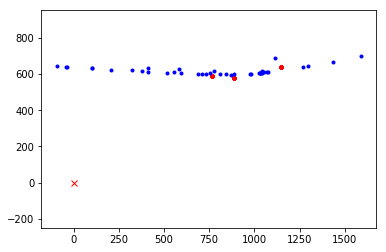

[[923.875]
 [605.375]]
[[ 767  767  767  767 1145  767  767  767 1145  888  767  888  767  767
   767  767  767  767 1145  888 1145  767 1145  767 1145  767 1145  767
  1145  767  888 1145 1145 1145 1145  767 1145 1145 1145  888]
 [ 588  588  588  588  638  588  588  588  638  577  588  577  588  588
   588  588  588  588  638  577  638  588  638  588  638  588  638  588
   638  588  577  638  638  638  638  588  638  638  638  577]]
Residual: 15003.422323919298


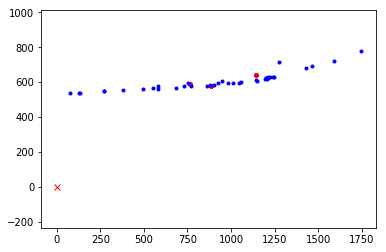

[[967.725]
 [609.825]]
[[ 767  888  767  888 1145  767  767  767 1145  888  767 1145  767  888
   767  767  888  767 1145 1145 1145  767 1145  888 1145  767 1145  888
  1145  767 1145 1145 1145 1145 1145  767 1145 1145 1145 1145]
 [ 588  577  588  577  638  588  588  588  638  577  588  638  588  577
   588  588  577  588  638  638  638  588  638  577  638  588  638  577
   638  588  638  638  638  638  638  588  638  638  638  638]]
Residual: 14272.634159649428


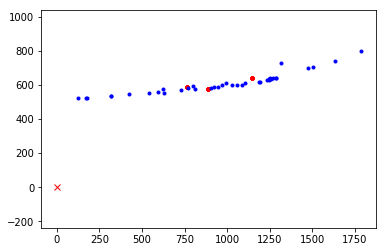

[[980.575]
 [612.875]]
[[ 767  888  767  888 1145  767  767  767 1145 1145  767 1145  767  888
   767  767 1145  767 1145 1145 1145  767 1145  888 1145  767 1145  888
  1145  767 1145 1145 1145 1145 1145  767 1145 1145 1145 1145]
 [ 588  577  588  577  638  588  588  588  638  638  588  638  588  577
   588  588  638  588  638  638  638  588  638  577  638  588  638  577
   638  588  638  638  638  638  638  588  638  638  638  638]]
Residual: 14483.114272944526


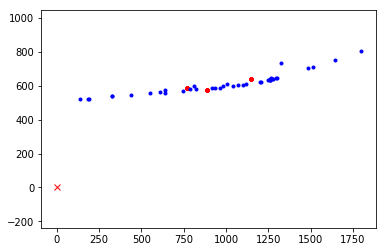

[[980.575]
 [612.875]]
[[ 767  888  767  888 1145  767  767  767 1145 1145  767 1145  767  888
   767  767 1145  767 1145 1145 1145  767 1145  888 1145  767 1145  888
  1145  767 1145 1145 1145 1145 1145  767 1145 1145 1145 1145]
 [ 588  577  588  577  638  588  588  588  638  638  588  638  588  577
   588  588  638  588  638  638  638  588  638  577  638  588  638  577
   638  588  638  638  638  638  638  588  638  638  638  638]]
Residual: 14582.631305885463


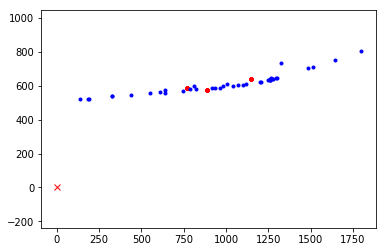

[[980.575]
 [612.875]]
[[ 767  888  767  888 1145  767  767  767 1145 1145  767 1145  767  888
   767  767 1145  767 1145 1145 1145  767 1145  888 1145  767 1145  888
  1145  767 1145 1145 1145 1145 1145  767 1145 1145 1145 1145]
 [ 588  577  588  577  638  588  588  588  638  638  588  638  588  577
   588  588  638  588  638  638  638  588  638  577  638  588  638  577
   638  588  638  638  638  638  638  588  638  638  638  638]]
Residual: 14582.631305885461
Converge 14582.631305885461 1.8189894035458565e-12 5
[[ 410.5268819   630.80531281]
 [ 779.53509651  616.38070868]
 [ 584.80842917  626.06677069]
 [ 688.92945938  599.67795989]
 [1035.38475782  604.78865788]
 [  99.51505001  631.80549814]
 [ -38.29995066  636.30417197]
 [  99.3974752   631.6082203 ]
 [1044.52117765  606.98070151]
 [ 840.6866774   598.87742216]
 [ 379.3509098   618.25439487]
 [ 888.85494273  600.98137443]
 [ -93.43811311  643.85497703]
 [ 708.78537311  600.95948806]
 [ 207.03878234  624.24407877]
 [ 597.10722702

In [ ]:
from __future__ import print_function

import pandas as pd
import os
import os.path

# Change this to where data is stored
radar_data_dir = os.path.join(data_dir, 'radar_detections')

# Change this to where data is stored
video_dir = data_dir

font                   = cv2.FONT_HERSHEY_SIMPLEX
topLeftCornerOfText    = (10,20)
fontScale              = 0.5
fontColor              = (0,0,0)
lineType               = 2
diffPosition           = 25

# UI sliders callback functions
def showText(frame):
    cv2.putText(frame, "x: " + str(round(cam.t[0], 3)) + " m", 
    topLeftCornerOfText, 
    font, 
    fontScale,
    fontColor,
    lineType)
    cv2.putText(frame, "y: " + str(round(cam.t[1], 3)) + " m", 
    (topLeftCornerOfText[0], topLeftCornerOfText[1]+1*diffPosition), 
    font, 
    fontScale,
    fontColor,
    lineType)
    cv2.putText(frame, "z: " + str(round(cam.t[2], 3)) + " m", 
    (topLeftCornerOfText[0], topLeftCornerOfText[1]+2*diffPosition), 
    font, 
    fontScale,
    fontColor,
    lineType)
    cv2.putText(frame, "Rx: " + str(round(cam.r[0], 3)) + " m", 
    (topLeftCornerOfText[0], topLeftCornerOfText[1]+3*diffPosition), 
    font, 
    fontScale,
    fontColor,
    lineType)
    cv2.putText(frame, "Ry: " + str(round(cam.r[1], 3)) + " m", 
    (topLeftCornerOfText[0], topLeftCornerOfText[1]+4*diffPosition), 
    font, 
    fontScale,
    fontColor,
    lineType)
    cv2.putText(frame, "Rz: " + str(round(cam.r[2], 3)) + " m", 
    (topLeftCornerOfText[0], topLeftCornerOfText[1]+5*diffPosition), 
    font, 
    fontScale,
    fontColor,
    lineType)

def changeTX(x):
    cam.t[0] = -(x - 10000)/1000.0
    
def changeTY(y):
    cam.t[1] = -(y - 10000)/1000.0
    
def changeTZ(z):
    cam.t[2] = -(z - 10000)/1000.0
    
def changeRX(x):
    cam.r[0] = (x - 10000)/1000.0/100.0
    
def changeRY(y):
    cam.r[1] = (y - 10000)/1000.0/100.0
    
def changeRZ(z):
    cam.r[2] = (z - 10000)/1000.0/100.0

def rescale_frame(frame, percent=75):
    width = int(frame.shape[1] * percent/ 100)
    height = int(frame.shape[0] * percent/ 100)
    dim = (width, height)
    return cv2.resize(frame, dim, interpolation =cv2.INTER_AREA)

# Reading a single tsv file by path
def read_table(path):
    try:
        return pd.read_csv(path, delimiter='\t', skiprows=[1])
    except pd.errors.EmptyDataError as ede:
        return []

# Reading all tsv files in a folder
def read_tables(folder):
    """reads all tables found in directory and concatenates them into one big
    table
    """
    common_table = pd.DataFrame()
    empty_files = []
    nparsed = 0

    for root, dirs, files in os.walk(folder):
        for f in [f for f in sorted(files) if os.path.splitext(f)[-1] == '.tsv']:
            # print('scanning file', f, '...', end=' ')
            try:
                # Основной вызов в чтении. delimiter='\t', чтобы считать табы разделителями,
                # skiprows=[1], чтобы пропустить строку с типами данных.
                table = pd.read_csv(os.path.join(root, f), delimiter='\t', skiprows=[1])
            except pd.errors.EmptyDataError as ede:
                # print('Empty file!!')
                empty_files.append(f)
            finally:
                # print(table.shape)
                common_table = common_table.append(table)

            nparsed += 1

    print('parsed', nparsed, 'files. Rows: ', common_table.shape[0], ' empty files number:', len(empty_files))
    print('empty files list: [', ', '.join(empty_files), ']\n')
    
    # чтобы установить сквозную нумерацию во всех прочитанных таблицах
    common_table = common_table.reset_index(drop=True)
    
    return common_table

def drawPoints(drawPoints, frame_todraw, size = 5, color = (0, 0, 0)):
    for point in drawPoints:
        x, y = int(point[0]*0.5), int(point[1]*0.5)
        if x < frame_todraw.shape[1] and y < frame_todraw.shape[0] and x > 0 and y > 0:
            cv2.circle(frame_todraw, (x, y), size, color, -1)

if __name__ == '__main__':
    cv2.destroyAllWindows()
    # table = read_table(os.path.join(radar_data_dir, 't24.305.028.tsv')) # Reading t24.305.028.tsv radar points only
    table = read_tables(radar_data_dir) # Reading all points # TODO: Fix reading data
    selectedDataTable = table.iloc[:, [1, 3, 4]]
    uniqueDataTable = selectedDataTable.grabMsec.unique()
    
    # Read camera detections
    camera_data_dir = os.path.join(data_dir, 'camera_detections')
    
    # camera_table = read_table(os.path.join(camera_data_dir, 't24.305.028.left.avi.tsv'))
    camera_table = read_tables(camera_data_dir)
    selectedCameraDataTable = camera_table.iloc[:, [2, 4, 5, 6, 7]]
    totalFrameNumber = 0 
    isFirstZero = False
    for index, row in selectedCameraDataTable.iterrows():
#         print(row)
        if row['FrameNumber'] == 0:
            if isFirstZero:
                print(currentValue)
                totalFrameNumber += currentValue
                isFirstZero = False
        elif not isFirstZero:
            isFirstZero = True    
        currentValue = row['FrameNumber']
        selectedCameraDataTable.at[index, 'FrameNumber'] = totalFrameNumber + currentValue
        selectedCameraDataTable.at[index, 'x'] = row['x'] + 0.5*row['w']
        selectedCameraDataTable.at[index, 'y'] = row['y'] + 0.5*row['h']
    
    cap = cv2.VideoCapture(os.path.join(video_dir, 't24.305.026-029.left.mov'))
    # Creating UI
    cv2.namedWindow('frame')
    cv2.createTrackbar('t_x', 'frame', 10159, 20000, changeTX)
    cv2.createTrackbar('t_y', 'frame', 8420, 20000, changeTY)
    cv2.createTrackbar('t_z', 'frame', 11257, 20000, changeTZ)
    cv2.createTrackbar('r_x', 'frame', 14164, 20000, changeRX)
    cv2.createTrackbar('r_y', 'frame', 7388, 20000, changeRY)
    cv2.createTrackbar('r_z', 'frame', 7797, 20000, changeRZ)
    
    pause = False
    # Change to what suits your system more
    key_space = 32
    
    # Current index of an element from yml.gz's grabmsec list
    grabmsecsIndex = 0
    # Current index of an element from radar tsv's grabmsec list
    radarDetectionsIndex = 0
    frame = None
    newRadarPoints = None
    while(True):
        if not pause:
            ret, frame = cap.read()
            newRadarPoints = None
            # Checking ret causes video to stop in the end
            #if ret is False:
            #    break
            
        if frame is None: # Loop video
            cap.set(cv2.CAP_PROP_POS_FRAMES, 0)
            grabmsecsIndex = 0
            radarDetectionsIndex = 0
            continue
        if not pause:
            frame = rescale_frame(frame, percent=50)
        if grabmsecsIndex >= len(grabmsecs):
            # There are no more frames to show
            continue
            
        # Calculate the radar grabmsec index closest to the camera grabmsec index
        while radarDetectionsIndex + 1 < len(uniqueDataTable) and uniqueDataTable[radarDetectionsIndex + 1] < grabmsecs[grabmsecsIndex]:
            radarDetectionsIndex += 1
            
        if radarDetectionsIndex+1 >= len(uniqueDataTable):
            # There are no more radar detections to show. 
            grabmsecsIndex += 1
            # Show frame without any detections and continue
            cv2.imshow('frame', frame)
            continue
        # Get current grabmsecs of both camera and radar
        currentGrabmsec = grabmsecs[grabmsecsIndex]
        
        currentFrameDetections = selectedDataTable.loc[selectedDataTable['grabMsec'] == uniqueDataTable[radarDetectionsIndex]]
        cartesianPoints = convertToCartesian(currentFrameDetections.values[:,-2:])
        points = cam.project(cartesianPoints)
        
        # Camera detections
        # WARNING: FRAME NUMBER IS THE SAME IN ALL FILES 026, 027, 028 avi tsv
        
        
        currentFrameCameraDetections = selectedCameraDataTable.loc[selectedCameraDataTable['FrameNumber'] == grabmsecsIndex]
        currentFrameCameraDetectionsValues = currentFrameCameraDetections.values[:, -4:-2]
        cartesianCameraPoints = np.array(list(map(lambda x: np.array([x[0], x[1], 0]), currentFrameCameraDetectionsValues)))
        frame_todraw = frame.copy() #don't draw on original frame
        
        drawPoints(gridPoints, frame_todraw, 2, (0, 0, 0))
        drawPoints(points, frame_todraw, color = (0,255,0))
        drawPoints(cartesianCameraPoints, frame_todraw, color = (193,0,32))
        if newRadarPoints is not None:
            drawPoints(newRadarPoints, frame_todraw, color = (255,255,0))
#         for point in gridPoints:
#             x, y = int(point[0]*0.5), int(point[1]*0.5)
#             if x < frame.shape[1] and y < frame.shape[0] and x > 0 and y > 0:
#                 cv2.circle(frame_todraw, (x, y), 2, (0,0,0), -1)
                
#         for point in points:
#             x, y = int(point[0]*0.5), int(point[1]*0.5)
#             if x < frame.shape[1] and y < frame.shape[0] and x > 0 and y > 0:
#                 cv2.circle(frame_todraw, (x, y), 5, (0,255,0), -1)
                
#         for point in cartesianCameraPoints:
#             x, y = int(point[0]*0.5), int(point[1]*0.5)
#             if x < frame.shape[1] and y < frame.shape[0] and x > 0 and y > 0:
#                 cv2.circle(frame_todraw, (x, y), 5, (193,0,32), -1)
        
        showText(frame_todraw)
        # Show frame with detections
        cv2.imshow('frame', frame_todraw)
        
        if not pause:
            # Go to the next camera grabmsec value
            grabmsecsIndex += 1
        # Checking if the user pressed q key to exit the video
        key = cv2.waitKey(1) & 0xFF
        if key == ord('q'): # Press 'Q' key to exit
            break
        if key == ord('a'):
            newRadarPoints = align(points, currentFrameCameraDetectionsValues)
            drawPoints(newRadarPoints, frame_todraw, color = (255,255,0))
            print(points)
            print(newRadarPoints)
            cv2.imshow('frame', frame_todraw)
        if key == key_space:
            pause = not pause
        
            
    # Destroing the video window
    cv2.destroyAllWindows()

In [ ]:
!python Radar_detections_script.py